# Week 01 — Optimization Intuition (Loss as Energy)

This notebook guides you through building physical intuition for loss landscapes and optimization dynamics. You'll:
- Visualize loss landscapes and understand gradient-based optimization
- Implement gradient descent, SGD, and momentum
- Experiment with learning rates and hyperparameters

---
### 📚 Theory & References

- [📖 **Week 01 Theory** — Optimization](theory.md)
- [Week 00a — AI Landscape (training loop overview)](../../01_intro/week00_ai_landscape/theory.md#7-the-training-loop)
- [Week 00b — Math & Data (calculus prerequisites)](../../01_intro/week00b_math_and_data/theory.md#3-part-ii-calculus-and-optimisation)

---

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

np.random.seed(42)

In [2]:

# ─── Result Cache Utility ────────────────────────────────────────────────────
# All computed results (trajectories, sweeps) are saved to disk so re-running
# the notebook skips expensive computation and loads from cache instead.
import os, pickle

CACHE_DIR = "cache_week01"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    """Pickle obj to CACHE_DIR/<key>.pkl"""
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)
    print(f"[cache] saved '{key}'")

def load_result(key):
    """Return unpickled object or None if not cached."""
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            obj = pickle.load(f)
        print(f"[cache] loaded '{key}' from {path}")
        return obj
    return None

def cached(key, compute_fn):
    """Return cached result if available; otherwise compute, save, and return."""
    result = load_result(key)
    if result is None:
        result = compute_fn()
        save_result(key, result)
    return result

print("Cache utility ready. Results will be stored in:", CACHE_DIR)


Cache utility ready. Results will be stored in: cache_week01


## 1. Visualize Simple Loss Landscapes

Create 2D grids and plot loss contours for quadratic and multimodal functions.

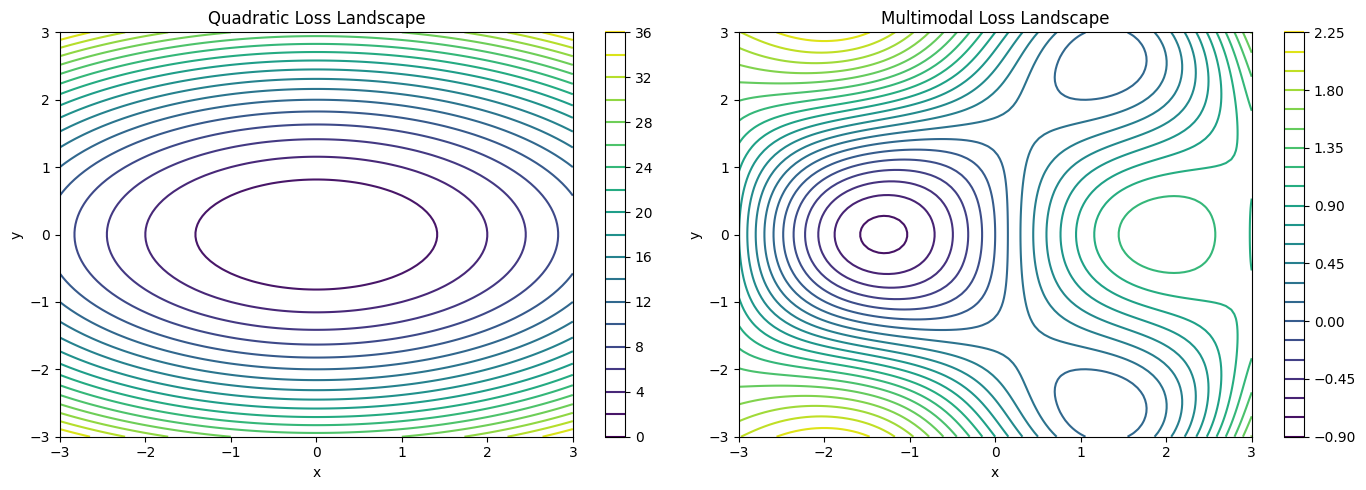

In [3]:
# Define loss functions
def quadratic(x, y):
    """Simple quadratic loss"""
    return x**2 + 3*y**2

def multimodal(x, y):
    """Multimodal loss with multiple local minima"""
    return np.sin(x) * np.cos(y) + 0.1*(x**2 + y**2)

# Create grid
x_range = np.linspace(-3, 3, 100)
y_range = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_range, y_range)

# Compute losses
Z_quad = quadratic(X, Y)
Z_multi = multimodal(X, Y)

# Plot contours
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Quadratic
contour1 = axes[0].contour(X, Y, Z_quad, levels=20, cmap='viridis')
axes[0].set_title('Quadratic Loss Landscape')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(contour1, ax=axes[0])

# Multimodal
contour2 = axes[1].contour(X, Y, Z_multi, levels=20, cmap='viridis')
axes[1].set_title('Multimodal Loss Landscape')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(contour2, ax=axes[1])

plt.tight_layout()
plt.show()

## 2. Gradient Descent Dynamics

Implement vanilla gradient descent and plot parameter trajectories.

[cache] saved 'gd_trajectory_lr0.1'


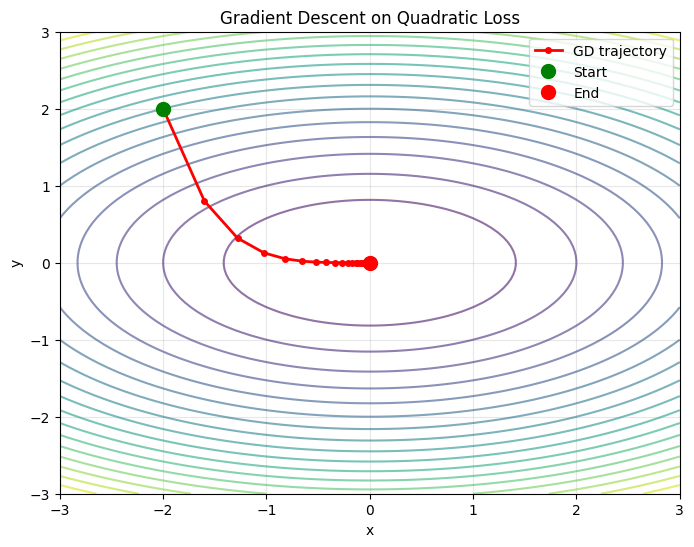

Final position: (-0.0000, 0.0000)
Final loss: 0.000000


In [4]:

# Gradient descent implementation
def gradient_descent(x0, y0, grad_fn, lr=0.1, n_steps=50):
    trajectory = [(x0, y0)]
    x, y = x0, y0
    for _ in range(n_steps):
        gx, gy = grad_fn(x, y)
        x -= lr * gx
        y -= lr * gy
        trajectory.append((x, y))
    return trajectory

def quad_gradient(x, y):
    return (2*x, 6*y)

# ── Cached GD trajectory ──────────────────────────────────────────────────────
trajectory_gd = cached(
    "gd_trajectory_lr0.1",
    lambda: gradient_descent(-2.0, 2.0, quad_gradient, lr=0.1, n_steps=50)
)

plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z_quad, levels=20, cmap='viridis', alpha=0.6)
traj_x = [p[0] for p in trajectory_gd]
traj_y = [p[1] for p in trajectory_gd]
plt.plot(traj_x, traj_y, 'r-o', markersize=4, linewidth=2, label='GD trajectory')
plt.plot(traj_x[0], traj_y[0], 'go', markersize=10, label='Start')
plt.plot(traj_x[-1], traj_y[-1], 'ro', markersize=10, label='End')
plt.title('Gradient Descent on Quadratic Loss')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(alpha=0.3); plt.show()
print(f"Final position: ({traj_x[-1]:.4f}, {traj_y[-1]:.4f})")
print(f"Final loss: {quadratic(traj_x[-1], traj_y[-1]):.6f}")


## 3. Momentum and Learning Rate Sweeps

Implement momentum and experiment with different learning rates.

[cache] saved 'momentum_trajectory_lr0.05_m0.5'


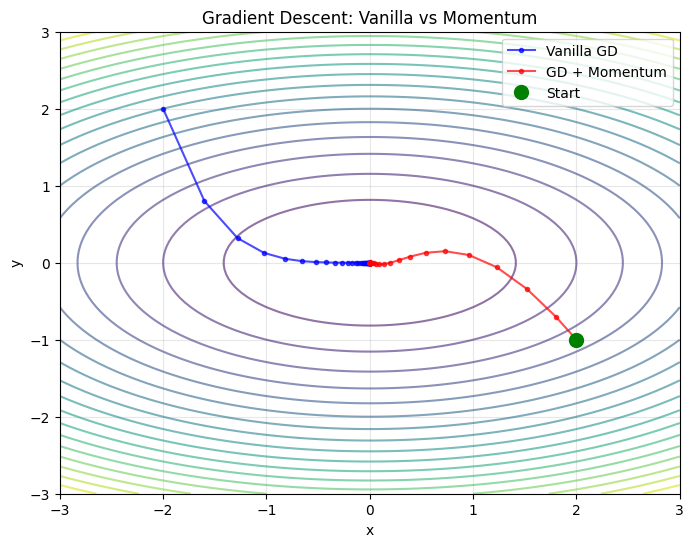

GD final loss: 0.000000
Momentum final loss: 0.000000


In [5]:

def gradient_descent_momentum(x0, y0, grad_fn, lr=0.1, momentum=0.9, n_steps=50):
    trajectory = [(x0, y0)]
    x, y = x0, y0
    vx, vy = 0.0, 0.0
    for _ in range(n_steps):
        gx, gy = grad_fn(x, y)
        vx = momentum * vx - lr * gx
        vy = momentum * vy - lr * gy
        x += vx; y += vy
        trajectory.append((x, y))
    return trajectory

# ── Cached momentum trajectory ────────────────────────────────────────────────
trajectory_momentum = cached(
    "momentum_trajectory_lr0.05_m0.5",
    lambda: gradient_descent_momentum(2.0, -1.0, quad_gradient, lr=0.05, momentum=0.5, n_steps=50)
)

plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z_quad, levels=20, cmap='viridis', alpha=0.6)
plt.plot(traj_x, traj_y, 'b-o', markersize=3, linewidth=1.5, label='Vanilla GD', alpha=0.7)
mom_x = [p[0] for p in trajectory_momentum]
mom_y = [p[1] for p in trajectory_momentum]
plt.plot(mom_x, mom_y, 'r-o', markersize=3, linewidth=1.5, label='GD + Momentum', alpha=0.7)
plt.plot(2.0, -1.0, 'go', markersize=10, label='Start')
plt.title('Gradient Descent: Vanilla vs Momentum')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(alpha=0.3); plt.show()
print(f"GD final loss: {quadratic(traj_x[-1], traj_y[-1]):.6f}")
print(f"Momentum final loss: {quadratic(mom_x[-1], mom_y[-1]):.6f}")


[cache] saved 'lr_sweep_quadratic'


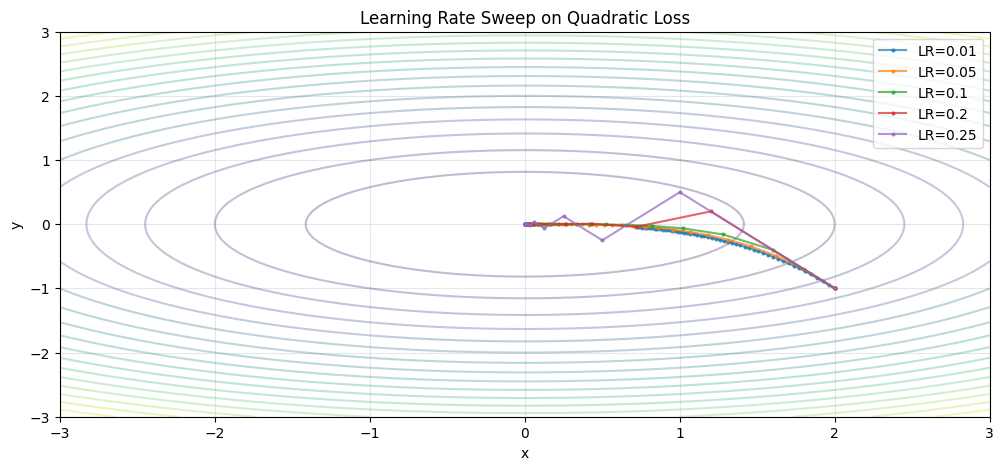

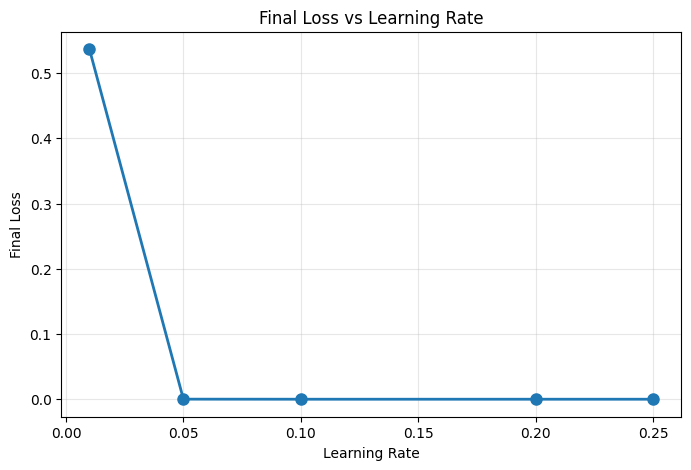

In [6]:

# ── Cached LR sweep ───────────────────────────────────────────────────────────
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.25]

def _compute_lr_sweep():
    return {lr: gradient_descent(2.0, -1.0, quad_gradient, lr=lr, n_steps=50)
            for lr in learning_rates}

lr_sweep_results = cached("lr_sweep_quadratic", _compute_lr_sweep)

final_losses = []
plt.figure(figsize=(12, 5))
plt.contour(X, Y, Z_quad, levels=20, cmap='viridis', alpha=0.3)
for lr in learning_rates:
    traj = lr_sweep_results[lr]
    tx = [p[0] for p in traj]; ty = [p[1] for p in traj]
    final_losses.append(quadratic(tx[-1], ty[-1]))
    plt.plot(tx, ty, '-o', markersize=2, label=f'LR={lr}', alpha=0.7)
plt.title('Learning Rate Sweep on Quadratic Loss')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(8, 5))
plt.plot(learning_rates, final_losses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Learning Rate'); plt.ylabel('Final Loss')
plt.title('Final Loss vs Learning Rate'); plt.grid(alpha=0.3); plt.show()


## Exercises for Further Practice

1. **Explore SGD**: Implement stochastic gradient descent with mini-batches on a simple regression dataset
2. **Saddle Points**: Create a saddle-point loss function and visualize optimizer behavior
3. **Cyclical Learning Rates**: Implement Leslie Smith's cyclical LR and compare to constant LR
4. **3D Visualization**: Create 3D surface plots of the loss landscapes
5. **Divergence Analysis**: Find learning rates that cause divergence and explain why

In [7]:

# EXERCISE 1 — Stochastic Gradient Descent (SGD)
# Goal: implement SGD where each update uses only a single random sample
# from a small synthetic regression dataset (X shape (100,1), y = 3x + noise).
# Compare the noisy SGD trajectory vs full-batch GD on the same loss contour.
# Expected insight: SGD oscillates but converges to a similar minimum with
# the right learning rate. Use cached() to store each run you want to revisit.


In [8]:

# EXERCISE 2 — Saddle Points
# Goal: define the function f(x, y) = x^2 - y^2 (classic saddle).
# Visualize the surface and contours. Run GD from (0.01, 0.01) — does it
# escape the saddle? Try adding small random noise to gradients (as in SGD).
# Expected insight: saddle points are common in non-convex losses; pure GD
# can stall there but noise helps escape.


In [9]:

# EXERCISE 3 — Cyclical Learning Rates (CLR)
# Goal: implement Leslie Smith's triangular LR policy: LR oscillates between
# base_lr=0.001 and max_lr=0.1 over a cycle of 10 steps.
# Apply it to GD on the quadratic loss and plot the trajectory alongside
# constant-LR GD on the same contour.
# Use cached() to store the CLR trajectory.
# Expected insight: CLR escapes local basins faster than constant LR.


In [10]:

# EXERCISE 4 — 3D Loss Surface Visualization
# Goal: create a 3D surface plot (use Axes3D / plot_surface) for the
# multimodal loss used in Exercise 2 (or invent your own).
# Overlay a GD trajectory by plotting each (x, y, loss(x,y)) point as
# a 3D scatter. Rotate the view to find the most revealing angle.
# Expected insight: 3D views surface structure invisible in 2D contours.


In [11]:

# EXERCISE 5 — Divergence Analysis
# Goal: run GD on the quadratic loss with LR values [0.3, 0.4, 0.5, 0.6].
# For each, compute loss at every step and plot on a log-scale.
# Find the exact threshold where divergence starts and explain WHY using
# the update rule: for f = x^2 + 3y^2, the condition is lr < 1/max_eigenvalue.
# Deliverable: a table of LR → "converges / diverges" with numerical evidence.


## Deliverables Checklist

- [ ] Loss landscape visualizations (quadratic + multimodal)
- [ ] GD/SGD/momentum implementations with trajectory plots
- [ ] Learning rate sweep analysis
- [ ] Short conclusions about convergence behavior and hyperparameter sensitivity

## Recommended Next Steps

- Review optimization sections in Goodfellow et al. "Deep Learning"
- Explore Leslie Smith's LR range test and cyclical LR papers
- Try implementing Adam optimizer (Week 02 preview)